In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')

In [2]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.ratio = 1
        #self.threshold = np.array([ 0.13973436,  0.07678319,  0.00016729,  0.00786861,  0.02336518])
        self.threshold = np.array([ 0.13973436,  0.07678319,  0.00016729,  0.00046861,  0.02336518])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        
        ac = self.agent.act(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = self.reward(self.obsr)
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,3,1)
        plt.plot(self.score_list[0:])
        plt.xlabel('episodes')
        plt.ylabel('cumulative reward')
        plt.subplot(1,3,2)
        plt.plot(self.rvg_list[0:])
        plt.xlabel('episodes')
        plt.ylabel('running average reward')
        plt.subplot(1,3,3)
        plt.plot(self.epi_list)
        plt.xlabel('episodes')
        plt.ylabel('number of time steps')
        plt.show()

# define an observer (new agent)

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 15000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = -3
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.load_model('agent_model/adversarial_agent2_distr233')

[2018-01-27 20:06:26,091] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [4]:
agn.learn()

-66.5629285485 [-66.562928548457592] [1000]
Episode 0	Last reward: -61.07629691846996	Average reward -65.70
('lagrange multiplier:', 0.4946146065523474, 'grad_norm:', 0.3499903864994423)
fval before -1.0046963261345354e-15
a/e/r 0.009855499367974287 0.009892292131046403 0.9962806635120849
fval after -0.009855499367975291
Episode 1	Last reward: -62.71430334208628	Average reward -67.93
('lagrange multiplier:', 0.4782226533648568, 'grad_norm:', 0.35507959443667575)
fval before -6.550315845288423e-18
a/e/r 0.009800756138730602 0.009564453067297168 1.0247063862168349
fval after -0.00980075613873061
Episode 2	Last reward: -68.52536421752659	Average reward -66.50
('lagrange multiplier:', 0.3895260090146461, 'grad_norm:', 0.450489974774038)
fval before 5.098421684834875e-16
a/e/r 0.00797416484216454 0.007790520180299258 1.0235728369370873
fval after -0.00797416484216403
Episode 3	Last reward: -62.606436804844535	Average reward -66.63
('lagrange multiplier:', 0.3708181880478161, 'grad_norm:', 0

('lagrange multiplier:', 0.6979732202874734, 'grad_norm:', 0.7652346357994928)
fval before -6.661338147750939e-18
a/e/r 0.014483675309769779 0.013959464405749928 1.0375523651039167
fval after -0.014483675309769786
Episode 30	Last reward: -62.841111014696324	Average reward -64.76
('lagrange multiplier:', 0.5330624424835348, 'grad_norm:', 0.6575374683918341)
fval before 8.165690346118027e-17
a/e/r 0.01175148198217433 0.01066124884967115 1.1022612967651355
fval after -0.01175148198217425
Episode 31	Last reward: -63.78899728707825	Average reward -64.44
('lagrange multiplier:', 0.44612449931856707, 'grad_norm:', 0.2753025832072256)
fval before 1.3322676295501878e-17
a/e/r 0.010005757181317429 0.008922489986371344 1.1214086198584388
fval after -0.010005757181317415
Episode 32	Last reward: -62.85142361702691	Average reward -63.75
('lagrange multiplier:', 0.5665158763200621, 'grad_norm:', 0.4187874925446414)
fval before 1.2168044349891717e-16
a/e/r 0.011237917877925776 0.01133031752640484 0.99

a/e/r 0.012417601325948121 0.012072159158633064 1.028614779077695
fval after -0.012417601325947982
Episode 59	Last reward: -62.546263804152495	Average reward -62.78
('lagrange multiplier:', 0.5026435239440102, 'grad_norm:', 0.4323825299012262)
fval before -6.926403894880195e-17
a/e/r 0.010830017268211216 0.010052870478882628 1.0773059586275469
fval after -0.010830017268211286
Episode 60	Last reward: -62.95848415955131	Average reward -63.84
('lagrange multiplier:', 0.38632878527046616, 'grad_norm:', 0.41967316036291336)
fval before -4.775346784668954e-16
a/e/r 0.007759170830157748 0.00772657570541154 1.0042185731414472
fval after -0.007759170830158226
Episode 61	Last reward: -67.00408349781021	Average reward -64.05
('lagrange multiplier:', 0.4187691314251073, 'grad_norm:', 0.49287157140130566)
fval before 1.7696955012524996e-16
a/e/r 0.00875708537648726 0.008375382628510288 1.0455743653642322
fval after -0.008757085376487082
Episode 62	Last reward: -62.82049918708436	Average reward -63.

('lagrange multiplier:', 0.7122235467060872, 'grad_norm:', 0.5134274167488728)
fval before -1.1723955140041654e-16
a/e/r 0.013958339971627935 0.014244470934122814 0.9799128403000599
fval after -0.013958339971628052
Episode 89	Last reward: -62.94189792528907	Average reward -62.91
('lagrange multiplier:', 0.5041615769193692, 'grad_norm:', 0.2431688280836976)
fval before -3.2751579226442116e-17
a/e/r 0.010100839466180187 0.0100832315383874 1.001746258401957
fval after -0.01010083946618022
Episode 90	Last reward: -62.58738237702787	Average reward -62.84
('lagrange multiplier:', 0.48740891286006893, 'grad_norm:', 0.24645824552099188)
fval before 1.0114131754335176e-16
a/e/r 0.010168774546578708 0.009748178257202008 1.043146142620644
fval after -0.010168774546578607
Episode 91	Last reward: -63.25053956315579	Average reward -63.32
('lagrange multiplier:', 0.5877652619413377, 'grad_norm:', 0.5140735794091439)
fval before 3.9811209884277334e-16
a/e/r 0.011620781196314581 0.01175530523883459 0.9

a/e/r 0.014141374159981578 0.01203760659044693 1.174766267175088
fval after -0.014141374159981504
Episode 118	Last reward: -63.428927674510916	Average reward -63.44
('lagrange multiplier:', 0.555590343227096, 'grad_norm:', 0.3902715354070363)
fval before 3.318456620604593e-16
a/e/r 0.009281883058604485 0.011111806864550324 0.8353171695429848
fval after -0.009281883058604154
Episode 119	Last reward: -63.15972097038442	Average reward -63.02
('lagrange multiplier:', 0.5526142386013916, 'grad_norm:', 0.4675004451871397)
fval before -2.768341111902828e-16
a/e/r 0.011197605926309728 0.011052284772022566 1.0131485170066394
fval after -0.011197605926310005
Episode 120	Last reward: -62.43160628758983	Average reward -63.00
('lagrange multiplier:', 0.5421319501301499, 'grad_norm:', 0.3708266952656227)
fval before -3.264610803910273e-16
a/e/r 0.01155136404898006 0.010842639002601023 1.0653646262878458
fval after -0.011551364048980385
Episode 121	Last reward: -61.464483422461896	Average reward -63.

Episode 147	Last reward: -63.206001542111515	Average reward -63.53
('lagrange multiplier:', 0.47953576660559716, 'grad_norm:', 0.394386974445084)
fval before 5.4511950509095185e-17
a/e/r 0.009631682493706033 0.009590715332112148 1.0042715439021235
fval after -0.00963168249370598
Episode 148	Last reward: -63.553406497550235	Average reward -63.27
('lagrange multiplier:', 0.4055557418369649, 'grad_norm:', 0.41953305804096)
fval before -4.1833203567875896e-16
a/e/r 0.007305614893833096 0.008111114836739002 0.9006918334755387
fval after -0.007305614893833514
Episode 149	Last reward: -63.2454546750138	Average reward -63.27
('lagrange multiplier:', 0.4237534210091468, 'grad_norm:', 0.5190532903947639)
fval before 1.2573275753879899e-16
a/e/r 0.008372541858143494 0.008475068420185517 0.9879025682202365
fval after -0.00837254185814337
Episode 150	Last reward: -62.828205394332386	Average reward -63.13
('lagrange multiplier:', 0.6772243405634294, 'grad_norm:', 0.8808033621697117)
fval before -5.2

('lagrange multiplier:', 0.3166964342273939, 'grad_norm:', 0.27368660539416334)
fval before -6.196709811945311e-16
a/e/r 0.006519732448105277 0.0063339286845469685 1.0293346788086861
fval after -0.0065197324481058964
Episode 177	Last reward: -63.34005187481428	Average reward -63.77
('lagrange multiplier:', 0.30166279996943335, 'grad_norm:', 0.2718948261653476)
fval before 1.0077494394522546e-15
a/e/r 0.006527128846356618 0.006033255999388942 1.081858427193823
fval after -0.00652712884635561
Episode 178	Last reward: -63.23654884424957	Average reward -63.31
('lagrange multiplier:', 0.37561248119535356, 'grad_norm:', 0.4755600684088649)
fval before -3.324007735727719e-16
a/e/r 0.007978580833808513 0.007512249623906873 1.062076106791978
fval after -0.007978580833808846
Episode 179	Last reward: -63.45801393002375	Average reward -63.72
('lagrange multiplier:', 0.30082681540762446, 'grad_norm:', 0.24338305884134967)
fval before 1.3805623311213822e-16
a/e/r 0.006140689130318499 0.0060165363081

a/e/r 0.006387660948295954 0.006379887398518183 1.0012184462345803
fval after -0.006387660948295825
Episode 206	Last reward: -63.685497571456985	Average reward -63.36
('lagrange multiplier:', 0.3745468906110886, 'grad_norm:', 0.3004494224090573)
fval before 6.017408793468349e-17
a/e/r 0.006972428862973189 0.007490937812221875 0.9307818377022553
fval after -0.006972428862973129
Episode 207	Last reward: -63.65403869815226	Average reward -63.31
('lagrange multiplier:', 0.2919121217263426, 'grad_norm:', 0.2800611398295764)
fval before 1.0030865027488289e-16
a/e/r 0.006489428055394753 0.0058382424345265645 1.1115379548161903
fval after -0.006489428055394653
Episode 208	Last reward: -63.12280422237815	Average reward -63.05
('lagrange multiplier:', 0.3154885515936339, 'grad_norm:', 0.2773907696516788)
fval before -2.229882944959627e-16
a/e/r 0.00582297205934748 0.006309771031873302 0.9228499782215874
fval after -0.005822972059347703
Episode 209	Last reward: -63.66040295368128	Average reward -

Episode 235	Last reward: -63.30212453725698	Average reward -63.52
('lagrange multiplier:', 0.3130523105088713, 'grad_norm:', 0.28339209400735593)
fval before -2.353672812205332e-16
a/e/r 0.006203222325272669 0.0062610462101775136 0.9907645011769997
fval after -0.006203222325272904
Episode 236	Last reward: -63.90438727668021	Average reward -63.58
('lagrange multiplier:', 0.44084904207431647, 'grad_norm:', 0.6824819701749145)
fval before 1.7946755193065656e-16
a/e/r 0.009228675054676944 0.008816980841483388 1.0466933319460736
fval after -0.009228675054676765
Episode 237	Last reward: -63.84192360892175	Average reward -63.45
('lagrange multiplier:', 0.37544178735508166, 'grad_norm:', 0.33412328889525633)
fval before 2.0941581801992015e-16
a/e/r 0.007506423485363417 0.007508835747101661 0.9996787435736392
fval after -0.007506423485363208
Episode 238	Last reward: -63.58495982321527	Average reward -63.55
('lagrange multiplier:', 0.3113671589911199, 'grad_norm:', 0.3126163384927236)
fval befor

('lagrange multiplier:', 0.31564592366248007, 'grad_norm:', 0.2934773081290789)
fval before -1.865174681370263e-17
a/e/r 0.006735790509958139 0.006312918473249499 1.0669851889424087
fval after -0.006735790509958158
Episode 265	Last reward: -62.45469810957382	Average reward -63.21
('lagrange multiplier:', 0.3887718097673808, 'grad_norm:', 0.4630195890710907)
fval before 2.6423307986078724e-17
a/e/r 0.007950883372355926 0.007775436195347785 1.0225642874046237
fval after -0.0079508833723559
Episode 266	Last reward: -59.974576343314155	Average reward -62.93
('lagrange multiplier:', 0.3639451365858808, 'grad_norm:', 0.47359630349408893)
fval before 2.5979218776228665e-17
a/e/r 0.006719659754598377 0.0072789027317175774 0.923169329536124
fval after -0.006719659754598351
Episode 267	Last reward: -63.65246847580812	Average reward -63.44
('lagrange multiplier:', 0.2808969539258623, 'grad_norm:', 0.2776891516769478)
fval before 1.588729148238599e-16
a/e/r 0.005842540410483311 0.00561793907851798

KeyboardInterrupt: 

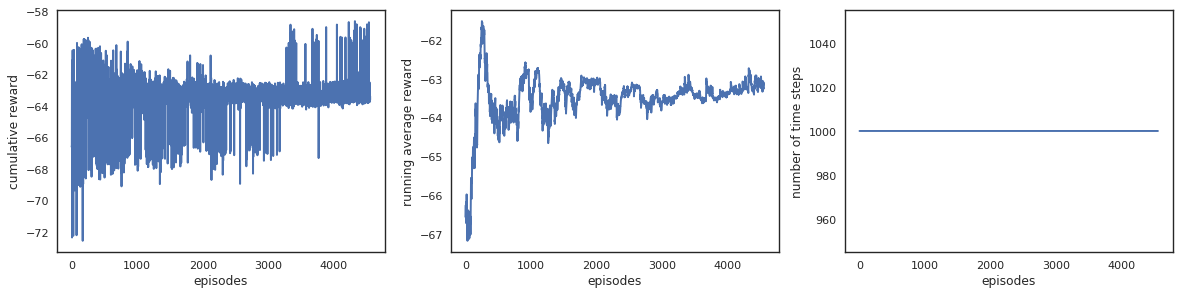

In [5]:
env.result_plot()

# Agent evaluation

In [6]:
env = adversial_env()
for i in range(100):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-01-27 21:42:38,731] Making new env: RoboschoolInvertedPendulum-v1


-62.500939481 [-62.500939480976371] [1000]


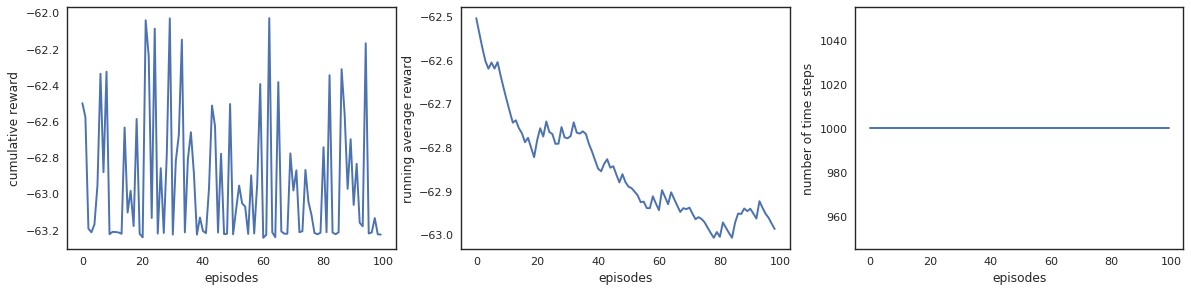

In [7]:
env.result_plot()

# Save model

In [8]:
agn.save_model('agent_model/adversarial_agent2_distr233')

In [9]:
env.total_score

-63.198851732341126